# Modeling ICU Data

<br>
To achieve the best machine learning model, I tried many different strategies and chased into countless rabbit holes, but (unsurprisingly) XGBoost tuned with GridSearchCV proved to be the best model for this data. The notebook is divided into the overall EDA portion, along with the final score, then the second half of the notebook details the numerous models and techniques used before deciding to stick with LogisticRegression.  <br> <br>

***

<br>

### Table of Contents
1. [Preliminary EDA](#Preliminary-EDA)
2. [Scoring](#Scoring)
3. [Primary Models](#Primary-Models)
4. [Other Models](#Other-Models)


**Attempted Strategies for Machine Learning**
1. [Feature Selection](#Feature-Selection) (OLS, Lasso, Recursive Feature Selection) 
2. Dropping data, imputing data (Mean, [MICE](#MICE))
3. Feature Engineering ([Standard Deviation](#Standard-Deviation), [Anomaly Detection](#Anomaly-Detection) with FBProphet module)
4. [Grid Search](#Grid-Search) and Threshold Tuning (Logistic, Random Forest, [XGBoost](#XGBoost))
5. [Oversampling](#Oversampling) (Random, Smote, Adasyn)
6. [Cross Validation](#Cross-Validation)
7. [Ensemble Methods](#Ensemble-Methods), Voting Classifier
8. Compare to dummy for sanity check

In [116]:
 %config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
import pickle

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import patsy
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [167]:
pickle_in = open("all_feature_counts.pickle","rb")
counts = pickle.load(pickle_in)
pickle_in = open("all_feature_means.pickle","rb")
vital_means = pickle.load(pickle_in)
pickle_in = open("all_feature_std.pickle","rb")
vital_std = pickle.load(pickle_in)

## Preliminary EDA 

In [168]:
#Some data cleaning (eliminate some sparse features, drop nulls)
important_vitals = vital_means.drop(columns = ['ALP', 'ALT', 'AST','Albumin','Bilirubin','Height',
                                               'Gender','Cholesterol','RespRate', 'TroponinI', 'TroponinT','SaO2'])
important_vitals['RecordID'] = important_vitals['RecordID'].astype(int)
for_impute = important_vitals
important_vitals = important_vitals.dropna()

Combining data with outcomes to begin modeling

In [169]:
with open("Outcomes.txt") as f:
    content = f.readlines()
    contents = [i.rstrip().split(',') for i in content[1:]]
outcomes = [[i[0],i[5]] for i in contents]

In [170]:
outcomes = pd.DataFrame(outcomes)
outcomes = outcomes.rename(columns = {0:'RecordID',1:'Outcome'})
outcomes = outcomes.astype(int)
combined = pd.merge(important_vitals, outcomes, on='RecordID', how='inner')

In [171]:
y = combined['Outcome']
X = combined.drop(columns = ['Outcome','RecordID'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)
X_tr, X_te = scale(X_train, X_test)

In [172]:
#Functions for modeling
def scale(X_train, X_test, X_val = np.empty([0,])):
    std = StandardScaler()
    std.fit(X_train.values)
    X_tr = std.transform(X_train.values)
    X_te = std.transform(X_test.values)
    
    #When I want to test the set and the data
    if X_val.size != 0 :
        X_va = std.transform(X_val.values)
        return X_tr, X_te, X_va
    return X_tr, X_te


In [173]:
#SCORING METRICS GIVEN CONFUSION MATRIX
def precision(matrix):
    if (matrix[1][1]+matrix[0][1]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[0][1])

def recall(matrix):
    if (matrix[1][1]+matrix[1][0]) == 0:
        return -1
    return matrix[1][1]/(matrix[1][1]+matrix[1][0])

def minScore(matrix):
    return min(precision(matrix),recall(matrix))

In [174]:
def print_heatmap(confusion):
    plt.figure(dpi=100)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g')

    plt.xlabel('Predicted Mortality')
    plt.ylabel('Actual Mortality')
    plt.title('Confusion Matrix');

In [175]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_te, y_test)))

The score for kNN is
Training:  85.01%
Test set:  82.24%


In [176]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_tr, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_te, y_test)))

The score for logistic regression is
Training:  85.01%
Test set:  84.15%


Wow! Such great accuracy! I'm a genius...but wait a minute, the mortality classes are so imbalanced.

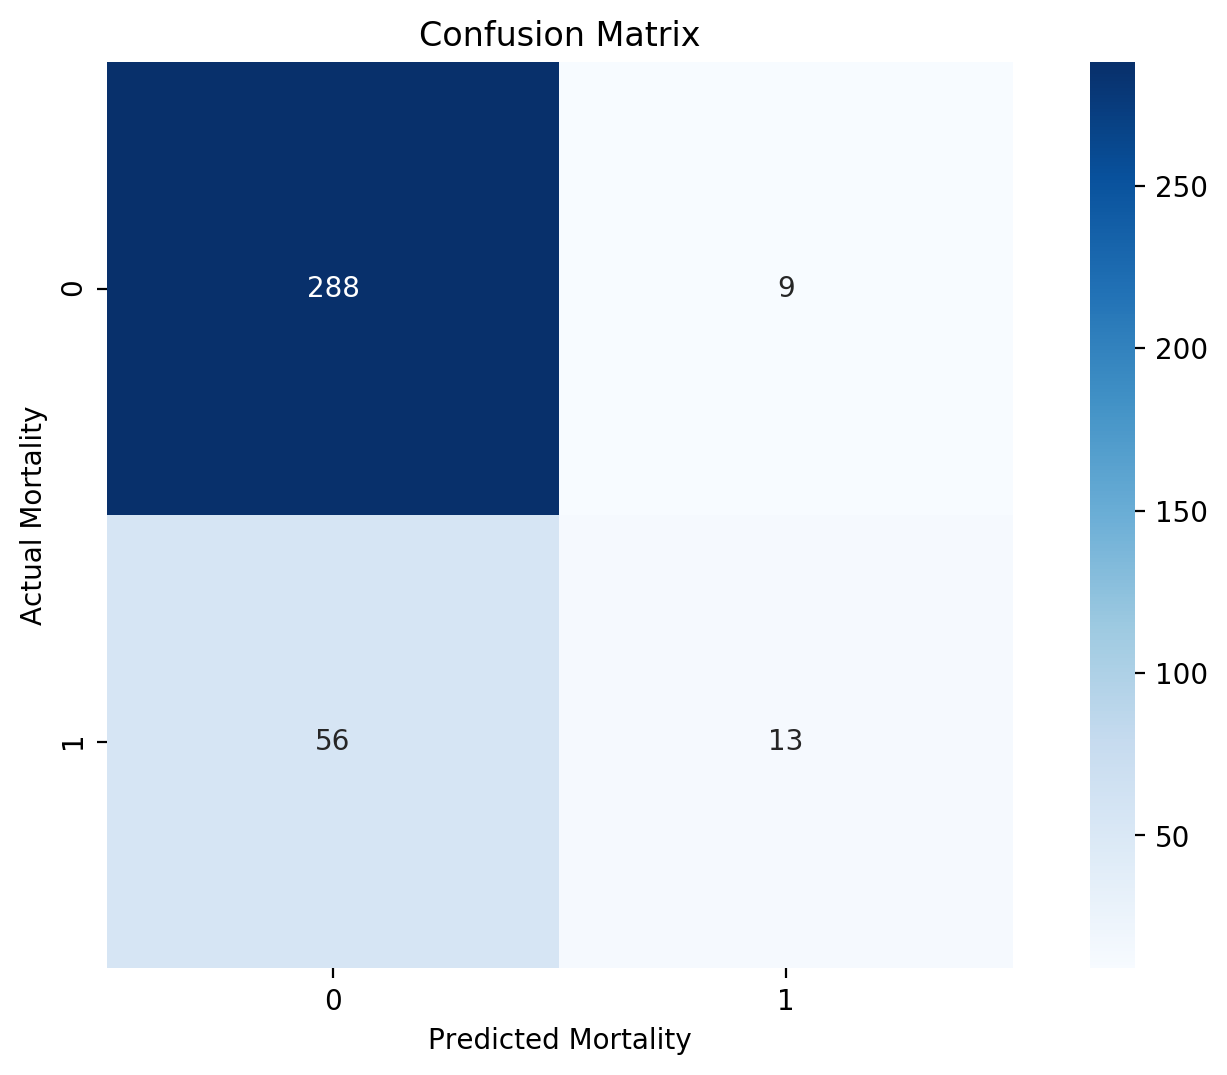

In [177]:
knn_confusion = confusion_matrix(y_test, knn.predict(X_te))
print_heatmap(knn_confusion)

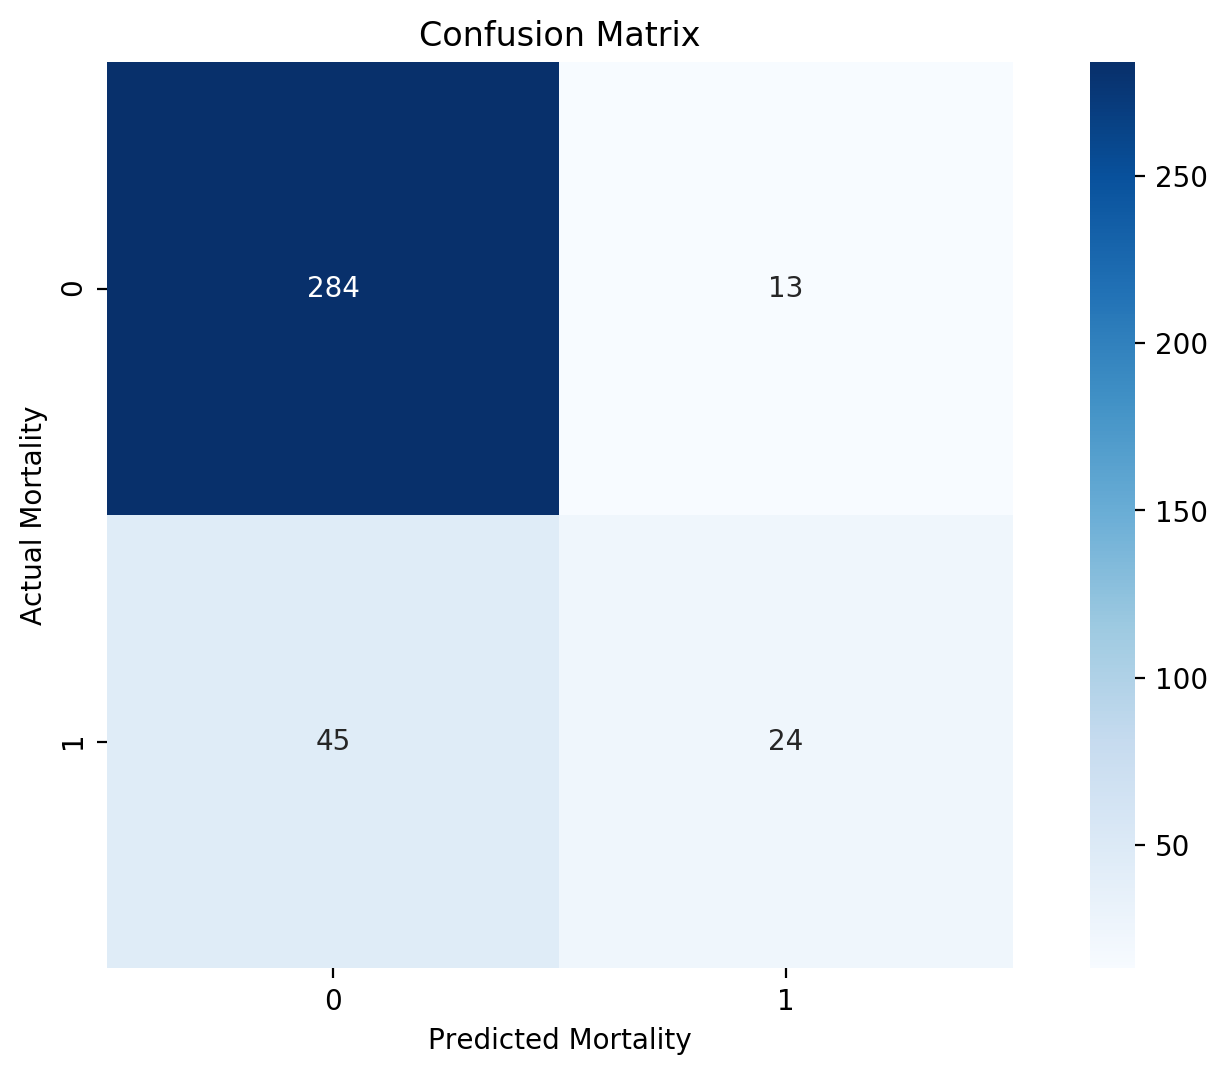

In [178]:
logit_confusion = confusion_matrix(y_test, logit.predict(X_te))
print_heatmap(logit_confusion)

## Scoring <br>
Well, what do you know, the score doesn't even make any sense *because our KNN model did not predict a single death!* <br><br>
Going forward, we are going to attempt to maximize the f1 score. While raising the recall to catch more patients at risk of mortality is good, I believe hospital resources are likely limited, so some balance of precision/recall should be reached.

In [179]:
def make_confusion_matrix(model, threshold, X, y):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X)[:, 1] >= threshold)
    return confusion_matrix(y, y_predict) 

#Score for a given threshold
def min_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return min(precision_score(y, y_predict), recall_score(y, y_predict))

#f1 score for a given threshold
def f1_threshold(model, threshold, X, y):
    y_predict = (model.predict_proba(X)[:, 1]>= threshold)
    return f1_score(y, y_predict)

In [180]:
#Find threshold to maximize contest score. Use train set, then maximize threshold on test set.
def max_score(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = min_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

In [181]:
#Find threshold to maximize contest score. Use train set, then maximize threshold on test set.
def max_f1(model, X, y):
    threshold = -1
    score = 0
    for i in np.linspace(0,.6,1001):
        temp = f1_threshold(model, i, X, y)
        if temp > threshold:
            threshold = temp
            score = i
    return [threshold,score]

In [182]:
def print_score(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_score(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

In [183]:
def print_f1(model, X, y):
    print(f"The max score for {type(model).__name__} is")
    maxscore = max_f1(model, X, y)
    print("Test set: {:6.2f}% ".format(100*maxscore[0]) + "at a threshold of {:.3f}".format(maxscore[1]))

In [184]:
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  50.31% at a threshold of 0.270


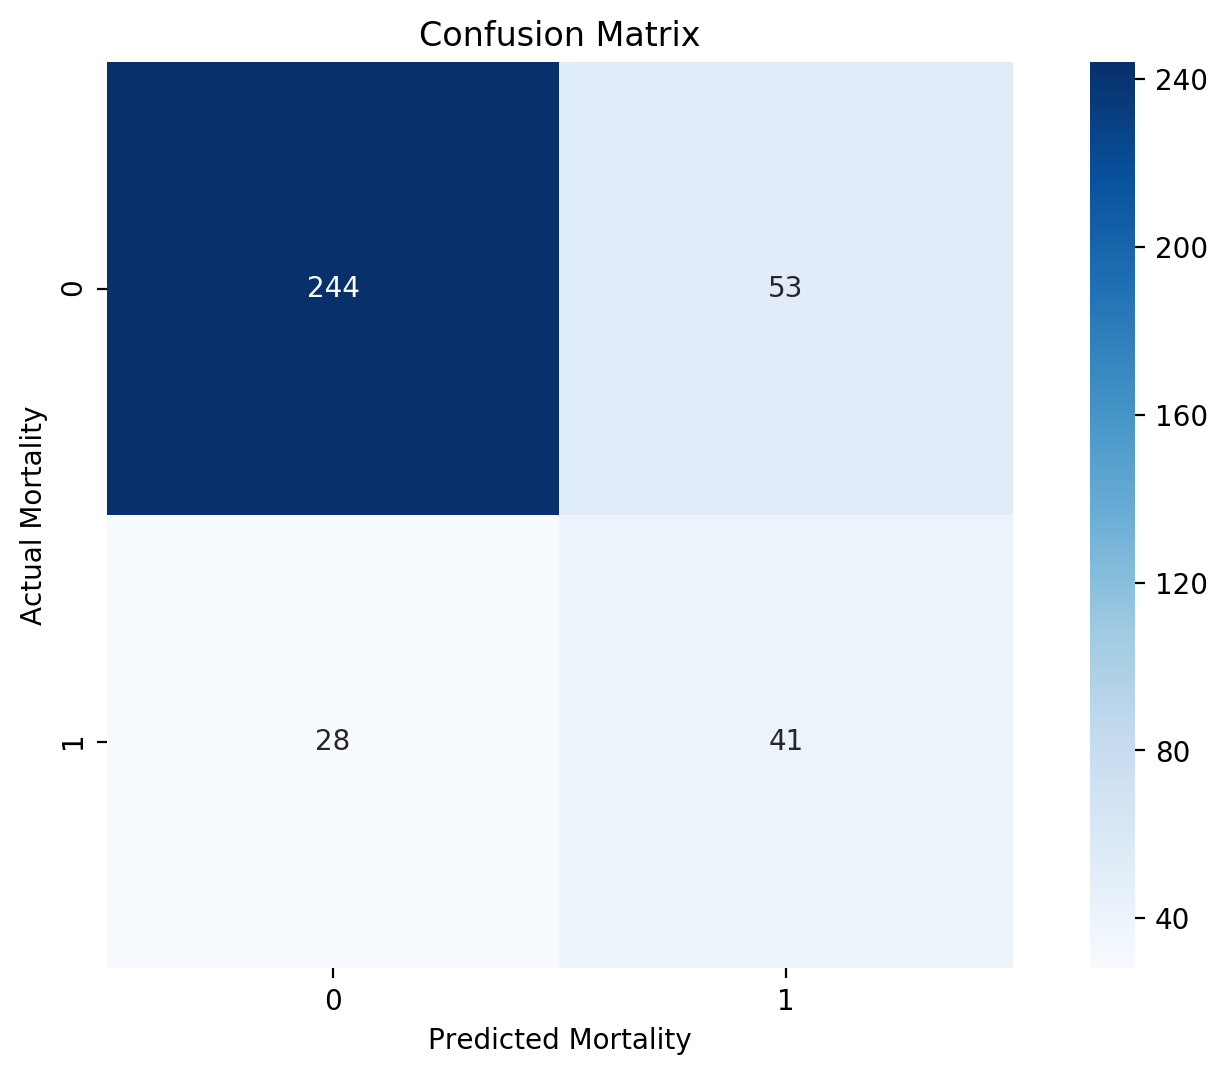

In [185]:
logit_confusion2 = make_confusion_matrix(logit, .270, X_te, y_test)
print_heatmap(logit_confusion2)

### Feature Selection 
First I tried using Recursive Feature Elimination to find features, but I would ultimately be able to get a better test prediction manually selecting features (based off OLS and Lasso), so I would abandon RFE.

In [186]:
from sklearn.feature_selection import RFE

rfe_selector = RFE(estimator=LogisticRegression(solver='lbfgs'), n_features_to_select=14, step=10, verbose=5)
rfe_selector.fit(X_tr, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 29 features.
Fitting estimator with 19 features.
14 selected features


In [187]:
rfe_feature

['Age',
 'BUN',
 'FiO2',
 'GCS',
 'Glucose',
 'HCT',
 'ICUType',
 'Lactate',
 'NIMAP',
 'PaCO2',
 'PaO2',
 'SysABP',
 'Urine',
 'Weight']

In [141]:
pickle_in = open("Combined.pickle","rb")
combined = pickle.load(pickle_in)

In [28]:
yXstring = 'Outcome ~ Age + BUN + Creatinine + DiasABP + FiO2 + GCS + Glucose + HCO3 +HCT + HR + ICUType + K + Lactate + MAP + MechVent + Mg +NIDiasABP + NIMAP + NISysABP + Na + PaCO2 + PaO2 + Platelets + SysABP + Temp + Urine + WBC + Weight + pH'
y, X = patsy.dmatrices(yXstring, data=combined, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     12.66
Date:                Mon, 05 Aug 2019   Prob (F-statistic):           4.63e-50
Time:                        12:59:35   Log-Likelihood:                -412.34
No. Observations:                1220   AIC:                             882.7
Df Residuals:                    1191   BIC:                             1031.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5392      0.311      1.734      0.083      -0.071       1.149
Age            0.0024      0.001      3.316      0.001       0.001       0.004
BUN            0.0040      0.001      5.327      0.000       0.003       0.005
Creatinine    -0.0120      0.011     -1.077      0.282      -0.034       0.010
DiasABP       -0.0003      0.002     -0.144      0.885      -0.004       0.003
FiO2           0.0042      0.099      0.042      0.966      -0.190       0.198
GCS           -0.0261      0.004     -6.804      0.000      -0.034      -0.019
Glucose        0.0006      0.000      2.088      0.037     3.4e-05       0.001
HCO3           0.0001      0.004      0.030      0.976      -0.007       0.008
HCT            0.0105      0.003      4.171      0.000       0.006       0.015
HR             0.0017      0.001      2.035      0.042    5.98e-05       0.003
ICUType        0.0309      0.011      2.774      0.006       0.009       0.053
K             -0.0056      0.024     -0.238      0.812      -0.052       0.041
Lactate        0.0350      0.006      5.391      0.000       0.022       0.048
MAP            0.0003      0.001      0.367      0.714      -0.001       0.002
MechVent       0.5392      0.311      1.734      0.083      -0.071       1.149
Mg            -0.0124      0.033     -0.371      0.711      -0.078       0.053
NIDiasABP   4.205e-05      0.002      0.017      0.986      -0.005       0.005
NIMAP         -0.0024      0.003     -0.733      0.464      -0.009       0.004
NISysABP       0.0009      0.001      0.726      0.468      -0.002       0.003
Na            -0.0038      0.003     -1.430      0.153      -0.009       0.001
PaCO2         -0.0032      0.002     -1.516      0.130      -0.007       0.001
PaO2          -0.0002      0.000     -1.092      0.275      -0.001       0.000
Platelets  -5.279e-05      0.000     -0.482      0.630      -0.000       0.000
SysABP        -0.0009      0.001     -0.911      0.362      -0.003       0.001
Temp          -0.0167      0.012     -1.340      0.180      -0.041       0.008
Urine         -0.0002      0.000     -2.114      0.035      -0.000   -1.58e-05
WBC            0.0006      0.002      0.379      0.705      -0.003       0.004
Weight        -0.0012      0.000     -2.948      0.003      -0.002      -0.000
pH             0.0043      0.003      1.674      0.094      -0.001       0.009
==============================================================================
Omnibus:                      195.434   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              293.980
Skew:                           1.162   Prob(JB):                     1.46e-64
Kurtosis:                       3.618   Cond. No.                     3.19e+15
==============================================================================

W

Let's see if we can improve the model by dropping some columns.

In [142]:
combinedDropped = combined.drop(columns = ['Creatinine','DiasABP','FiO2','Glucose', 'HCO3','K','MAP','MechVent','Mg','Na','NIMAP','NISysABP','NIDiasABP','Platelets','Temp','PaO2', 'SysABP','WBC'])

In [143]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_train)
print_f1(knn, X_te, y_test)

The max score for KNeighborsClassifier is
Test set:  47.11% at a threshold of 0.001


In [146]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  50.31% at a threshold of 0.270


Our model improved significantly by dropping collinear columns! Interesting. <br>
Removing these columns actually improved the logistic regression by a slight amount, while KNN was predictably unaffected.

### MICE

Ultimately, this project is based on a competition where all values had to be precicted in the test set. So we must find a way to use our model on all of the data. 
- Using Multiple imputation by Chained Equations (MICE) to fill in missing values for columns with fewer than half the values missing. 
- The actual imputation code for the data is in the import file, but here is just an example.
- Also, we are using the entire dataset from the competition (4000 train, 4000 test, 4000 for final scoring)


In [147]:
import statsmodels.imputation.mice as smi
#Use MICE to impute date
def impute(data, outcomes):
    imp = smi.MICEData(pd.merge(data, outcomes, on='RecordID'))
    imp.update_all(10)
    impute = imp.data
    return impute

First imputing just the mean for the data.

In [148]:
pickle_in = open("regtrain.pickle","rb")
regtrain = pickle.load(pickle_in)
pickle_in = open("regtest.pickle","rb")
regtest = pickle.load(pickle_in)
pickle_in = open("regval.pickle","rb")
regval = pickle.load(pickle_in)

In [149]:
y_train, X_train= regtrain['Outcome'], regtrain.drop(columns = ['Outcome','RecordID'])
y_test, X_test = regtest['Outcome'], regtest.drop(columns = ['Outcome','RecordID'])
X_tr, X_te = scale(X_train, X_test)

In [150]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  48.95% at a threshold of 0.209


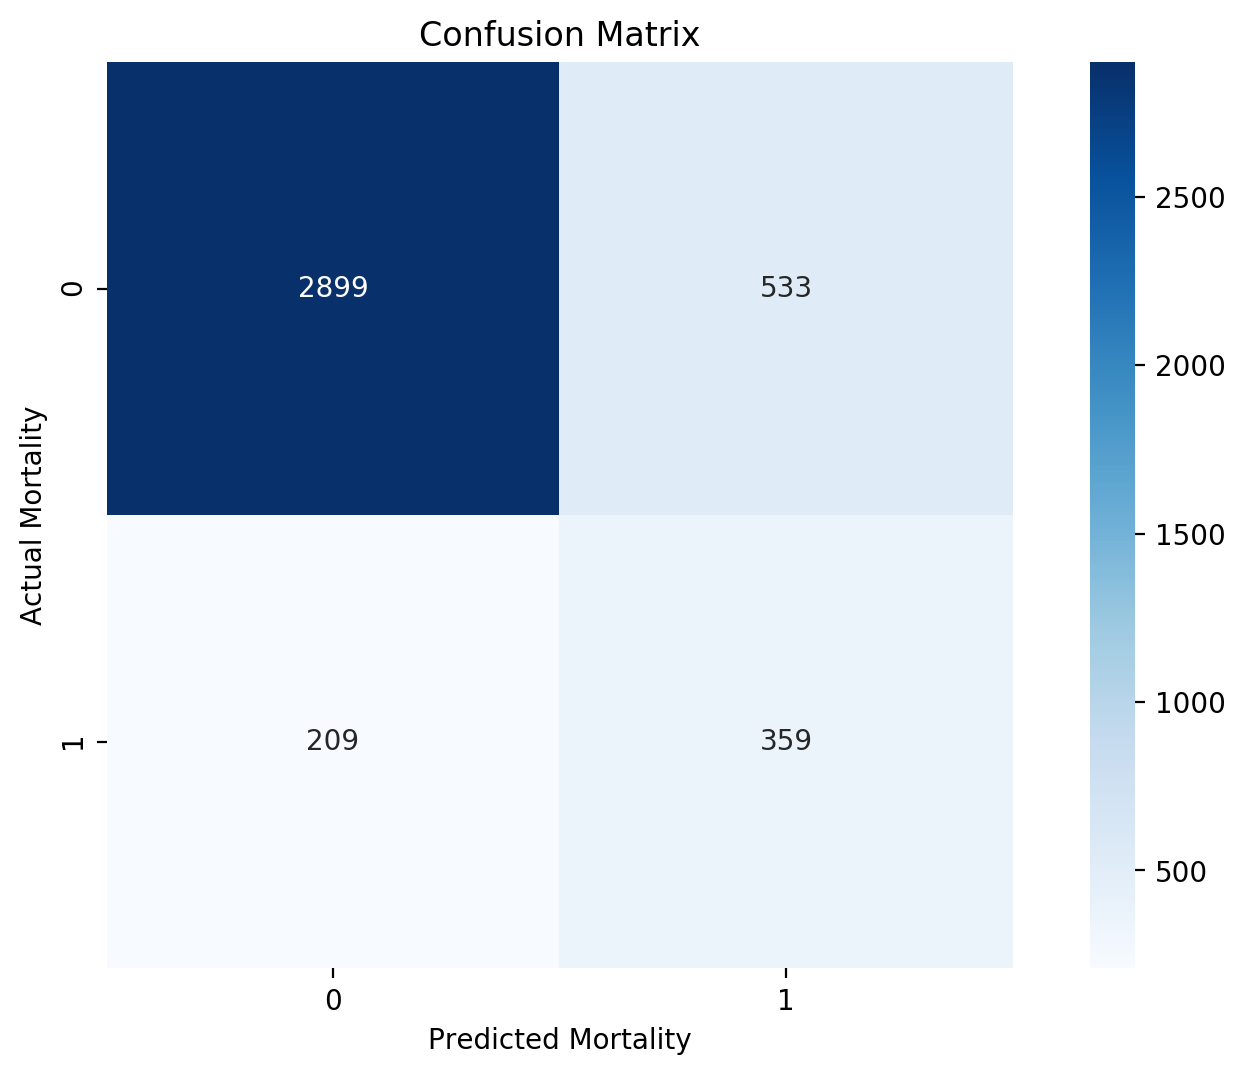

In [157]:
logit_confusion = make_confusion_matrix(logit, .209, X_te, y_test)
print_heatmap(logit_confusion)

In [152]:
import statsmodels.imputation.mice as smi

In [153]:
#use MICE do impute missing data
imp = smi.MICEData(for_impute)
imp.update_all(5)
impute = imp.data
imputed = pd.merge(impute, outcomes, on='RecordID', how='inner')

Reading in the imputed files from the data cleaning notebook.

In [220]:
pickle_in = open("imputed.pickle","rb")
imputed = pickle.load(pickle_in)
pickle_in = open("imputed_test.pickle","rb")
imputed_test = pickle.load(pickle_in)
pickle_in = open("imputed_val.pickle","rb")
imputed_val = pickle.load(pickle_in)

In [221]:
y_train, X_train= imputed['Outcome'], imputed.drop(columns = ['Outcome','RecordID'])
y_test, X_test = imputed_test['Outcome'], imputed_test.drop(columns = ['Outcome','RecordID'])
y_val, X_val = imputed_val['Outcome'], imputed_val.drop(columns = ['Outcome','RecordID'])
X_tr, X_te, X_va = scale(X_train, X_test, X_val)

The max score for LogisticRegression is
Test set:  49.47% at a threshold of 0.235


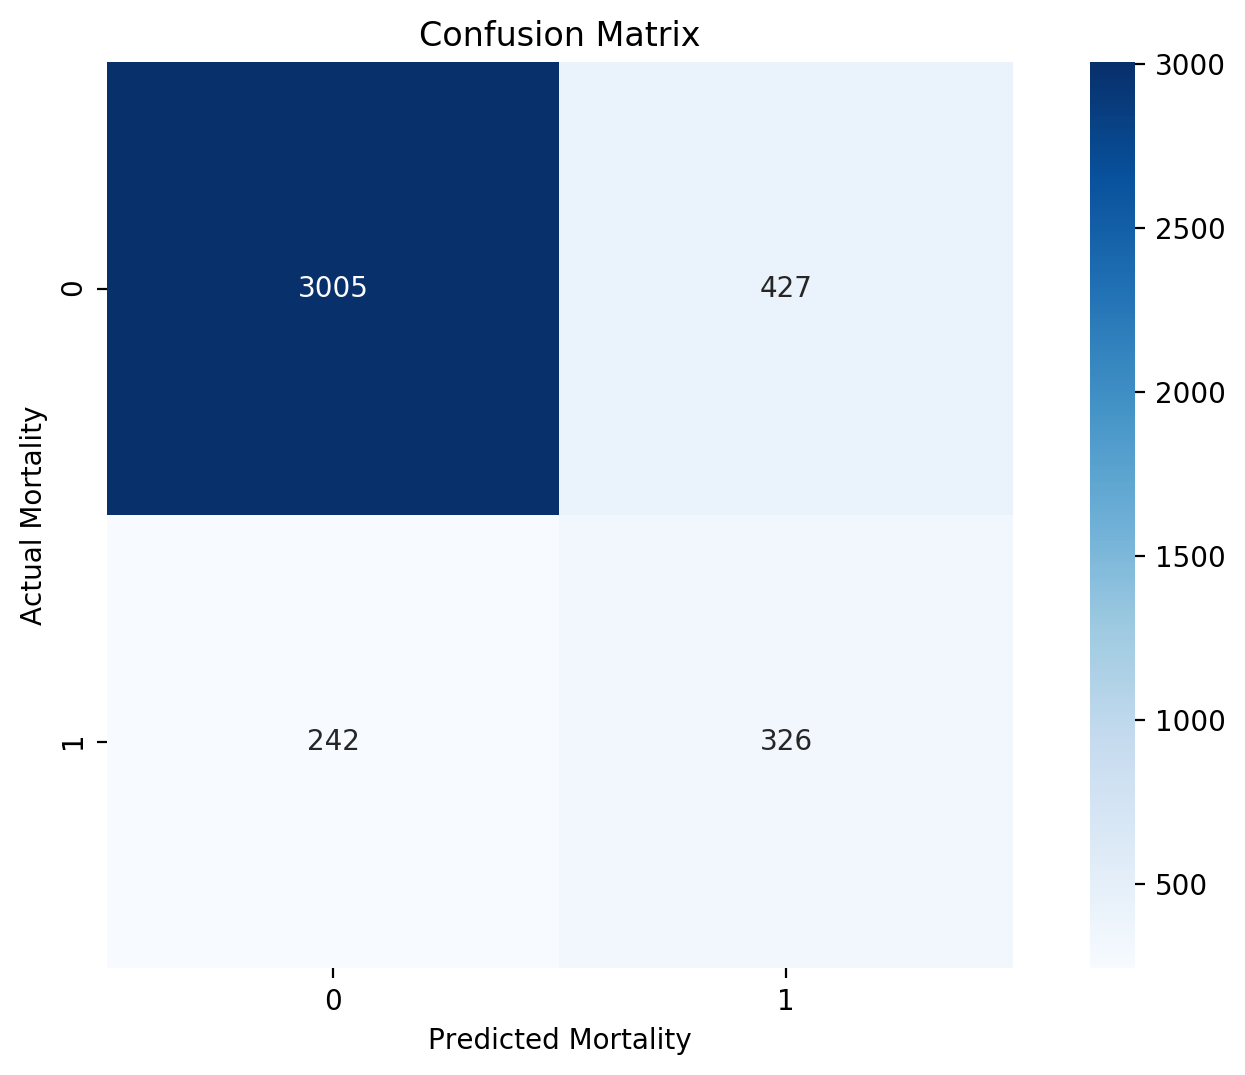

In [222]:
logit = LogisticRegression(solver = 'lbfgs')
logit.fit(X_tr, y_train)
logit_confusion = make_confusion_matrix(logit, .235, X_te, y_test)
print_heatmap(logit_confusion)
print_f1(logit, X_te, y_test)

MICE considerably improved my score. Success!

### Standard Deviation

My hypothesis was that patients who had multiple readings of some feature that exhibited large standard deviations could indicate failing health, so I tried to add standard deviations of a few features as a feature.

In [134]:
pickle_in = open("imputed_std.pickle","rb")
imputed_std = pickle.load(pickle_in)
pickle_in = open("imp_std_test.pickle","rb")
imp_std_test = pickle.load(pickle_in)
pickle_in = open("imp_std_val.pickle","rb")
imp_std_val = pickle.load(pickle_in)

In [136]:
yXstring = 'Outcome ~ BUN_std + Creatinine_std + DiasABP_std + FiO2_std + GCS_std + Glucose_std + HCO3_std +HCT_std + HR_std + K_std + MAP_std + Mg_std + PaCO2_std + PaO2_std + Platelets_std + SysABP_std + Temp_std+ Urine_std + WBC_std + pH_std'
y, X = patsy.dmatrices(yXstring, data=imputed_std, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     8.737
Date:                Sun, 04 Aug 2019   Prob (F-statistic):           4.65e-26
Time:                        04:22:27   Log-Likelihood:                -1337.9
No. Observations:                4000   AIC:                             2718.
Df Residuals:                    3979   BIC:                             2850.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0824      0.024      3.429      0.001       0.035       0.130
BUN_std            0.0019      0.002      1.043      0.297      -0.002       0.005
Creatinine_std     0.0472      0.025      1.878      0.060      -0.002       0.096
DiasABP_std       -0.0045      0.002     -2.233      0.026      -0.008      -0.001
FiO2_std          -0.1862      0.069     -2.689      0.007      -0.322      -0.050
GCS_std           -0.0134      0.004     -3.409      0.001      -0.021      -0.006
Glucose_std        0.0005      0.000      3.313      0.001       0.000       0.001
HCO3_std           0.0029      0.005      0.638      0.524      -0.006       0.012
HCT_std            0.0033      0.004      0.804      0.422      -0.005       0.011
HR_std             0.0054      0.001      4.602      0.000       0.003       0.008
K_std              0.0011      0.017      0.068      0.946      -0.032       0.034
MAP_std            0.0025      0.001      1.985      0.047    3.17e-05       0.005
Mg_std            -0.0188      0.030     -0.624      0.533      -0.078       0.040
PaCO2_std          0.0015      0.002      0.790      0.430      -0.002       0.005
PaO2_std          7.5e-06      0.000      0.049      0.961      -0.000       0.000
Platelets_std  -3.838e-05      0.000     -0.147      0.883      -0.001       0.000
SysABP_std         0.0022      0.001      1.949      0.051   -1.27e-05       0.004
Temp_std          -0.0007      0.004     -0.180      0.857      -0.008       0.007
Urine_std         -0.0003   5.21e-05     -6.450      0.000      -0.000      -0.000
WBC_std            0.0091      0.003      3.469      0.001       0.004       0.014
pH_std             0.0018      0.001      1.942      0.052   -1.78e-05       0.004
==============================================================================
Omnibus:                     1381.919   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3436.474
Skew:                           1.975   Prob(JB):                         0.00
Kurtosis:                       5.239   Cond. No.                     2.23e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Based off the OLS coefficients and p values, selecting two standard deviation features that seem to make some impact on regression.

In [233]:
stdgories = ['GCS_std','Glucose_std','HR_std','WBC_std']

In [247]:
#Bring in combined data with these features
pickle_in = open("all_train.pickle","rb")
all_train = pickle.load(pickle_in)
pickle_in = open("all_test.pickle","rb")
all_test = pickle.load(pickle_in)
pickle_in = open("all_val.pickle","rb")
all_val = pickle.load(pickle_in)

In [248]:
X_train, y_train= all_train.drop(columns = ['Outcome','RecordID']), all_train['Outcome']
X_test, y_test = all_test.drop(columns = ['Outcome','RecordID']), all_test['Outcome']
X_val, y_val = all_val.drop(columns = ['Outcome','RecordID']), all_val['Outcome']
X_tr, X_te, X_va = scale(X_train, X_test, X_val)

In [249]:
logit_all = LogisticRegression(solver = 'lbfgs')
logit_all.fit(X_tr, y_train)
print_f1(logit_all, X_te, y_test)

The max score for LogisticRegression is
Test set:  49.77% at a threshold of 0.247


In [230]:
coefs = pd.DataFrame(list(zip(X.columns,list(logit_all.coef_[0]))))

In [243]:
coefs

,0,1
0,Age,0.359078
1,BUN,0.476096
2,Creatinine,-0.038217
3,DiasABP,-0.224608
4,FiO2,0.242023
5,GCS,-0.770674
6,Glucose,0.129118
7,HCO3,0.058027
8,HCT,0.061578
9,HR,0.255930


This is the best score yet, and will ultimately prove to be the best reliable score.

In [226]:
#Testing Naive Bayes, not quite as good as logistic regression here
nb_all = BernoulliNB()
nb_all.fit(X_tr, y_train)
print_f1(nb_all, X_te, y_test)

The max score for BernoulliNB is
Test set:  42.25% at a threshold of 0.167


## Primary Models

### Grid Search

**Random Forest**

In [461]:
from sklearn.model_selection import GridSearchCV

In [333]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = 2)

In [334]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   22.9s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 864 out of 864 | elapsed:  9.6min finished


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [250]:
rf_all = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features = 3,
 min_samples_leaf= 3,
 min_samples_split= 10,
 n_estimators= 100)

In [251]:
rf_all.fit(X_tr, y_train)
print_f1(rf_all, X_te, y_test)

The max score for RandomForestClassifier is
Test set:  49.32% at a threshold of 0.228


In [510]:
pickle_out = open("RandomForestModel","wb")
pickle.dump(rf_all, pickle_out)

The RandomForest is a slight improvement over Logistic.

## XGBoost

In [252]:
xgb = XGBClassifier()
xgb.fit(X_tr, y_train);
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  51.65% at a threshold of 0.175


In [254]:
f1_threshold(xgb, .175, X_va, y_val)

0.5111252383979658

XGBoost to the flipping rescue! Even without gridsearch it beats other models handily.

In [527]:
param_grid = {
    'learning_rate': [.01, .03, .06, .1],
    'subsample': [.8, .85, .9, .95, 1],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [.3, .4, .6, .8, 1],
    'gamma': [0, 1, 5]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = 2)

In [528]:
grid_search.fit(X_tr, y_train)
grid_search.best_params_

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   54.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed: 11.0min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed: 12.7min finished


{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'subsample': 0.9}

In [255]:
xgb = XGBClassifier(colsample_bytree = 0.8, gamma=1, learning_rate=.1, max_depth=3, subsample=0.9)
xgb.fit(X_tr, y_train);

In [256]:
print_f1(xgb, X_te, y_test)

The max score for XGBClassifier is
Test set:  51.35% at a threshold of 0.241


In [260]:
f1_threshold(xgb, .241, X_va, y_val)

0.5205047318611987

In [532]:
print_score(xgb, X_va, y_val)

The max score for XGBClassifier is
Test set:  52.30% at a threshold of 0.286


In [32]:
pickle.dump(xgb, open('XGB.pickle.dat',"wb"))

**Logistic Regression**

In [469]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
             'solver' : ['liblinear'],
             'penalty' : ['l1','l2']}

grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5)
grid.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best paramters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.87
Best paramters:  {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [471]:
param_grid = {'C' : [0.001, 0.01, 0.1, 1, 10],
             'solver' : ['lbfgs']}

grid = GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=5)
grid.fit(X_tr, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best paramters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

Best cross-validation score: 0.87
Best paramters:  {'C': 0.01, 'solver': 'lbfgs'}
Best estimator:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Grid Search is not super helpful with logistic regression. I tried every permutation of LogisticRegression paramaters (L1, L2, Elastinet with different hyperparamaters), but the suggested paramters do worse on the test set. 
**Winner in a landslide is: XGBoost**

### Precision/Recall and ROC Curves

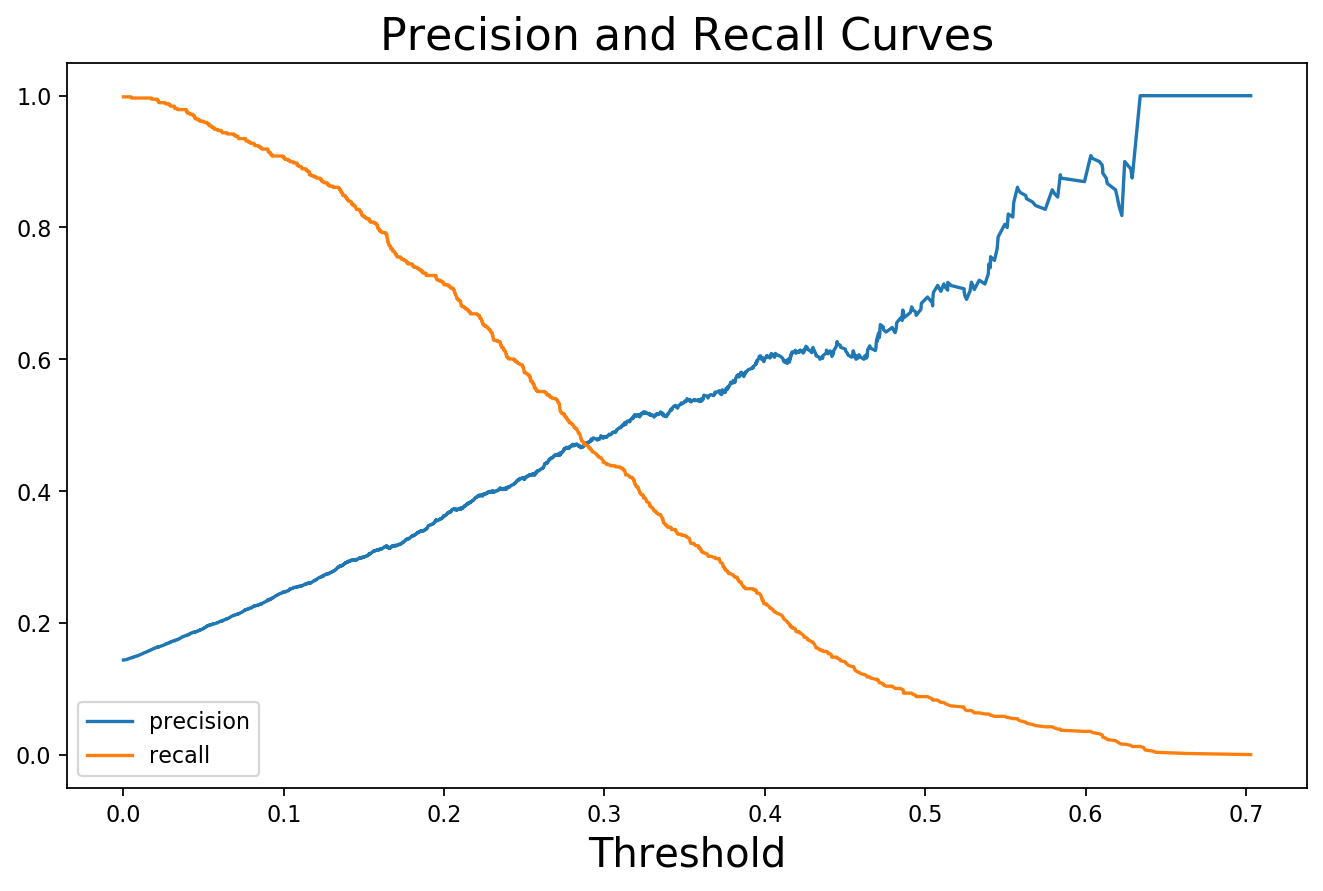

In [83]:
#precision_curve for this latest random forest model
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, rf_all.predict_proba(X_te)[:,1] )
plt.figure(dpi=80, figsize=(10,6))

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold', fontsize=18);
plt.title('Precision and Recall Curves', fontsize=20);

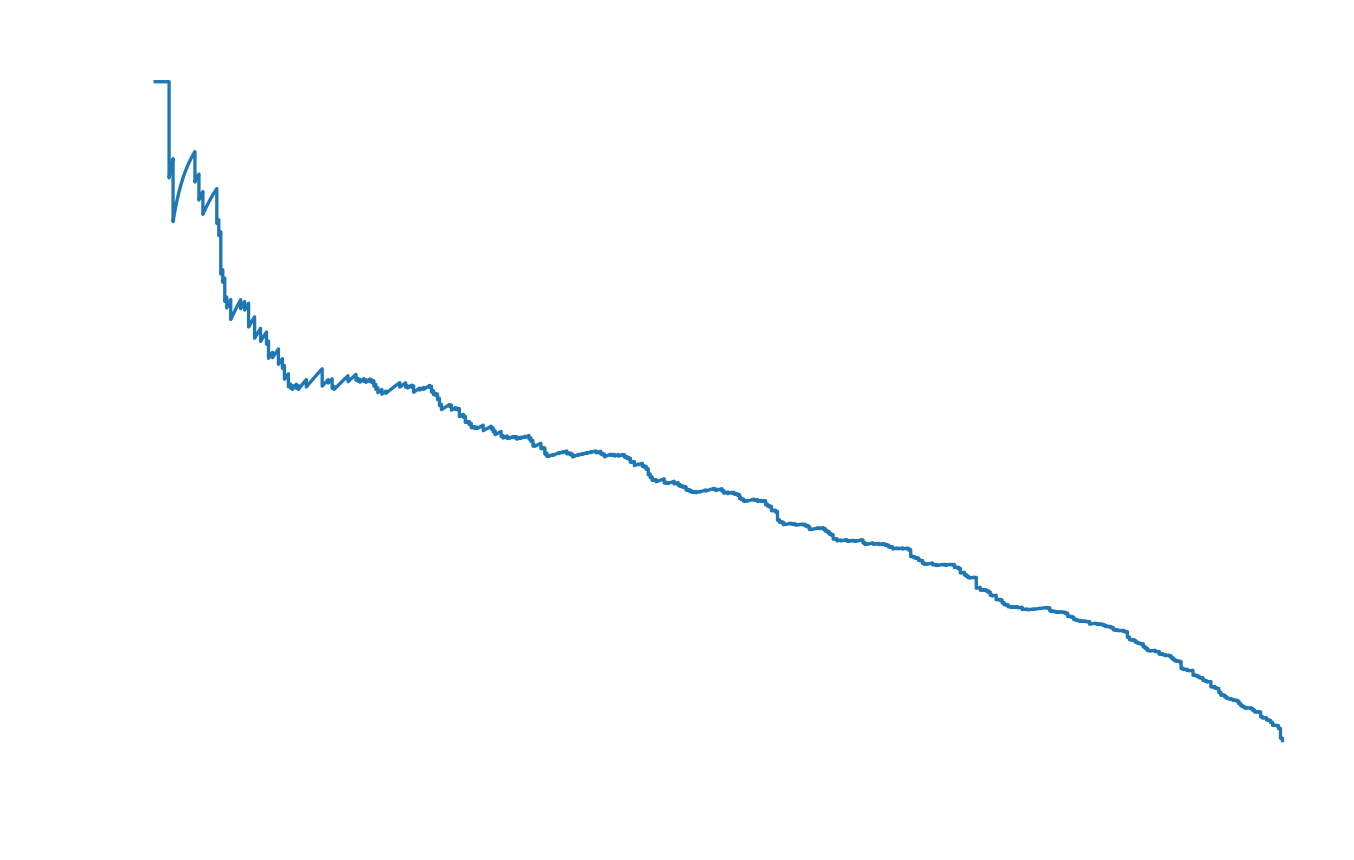

In [74]:
plt.figure(dpi=80, figsize=(10,6))
plt.rcParams['figure.figsize'] = (10.0, 6)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import metrics

In [84]:
def plot_AUC(X, y, model):
    fpr, tpr, thresh = metrics.roc_curve(y, model.predict_proba(X)[:,1])
    auc = metrics.roc_auc_score(y, model.predict_proba(X)[:,1])
    plt.plot(fpr,tpr,label=type(model).__name__)
    plt.plot([0,1],[0,1],ls='--')
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.legend(loc=4);
    
    plt.xlabel('False positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.title('ROC curve for Mortality Prediction', fontsize=22);
    print(type(model).__name__ + " ROC AUC score : {:f}".format(roc_auc_score(y, model.predict_proba(X)[:,1])))

RandomForestClassifier ROC AUC score : 0.828651


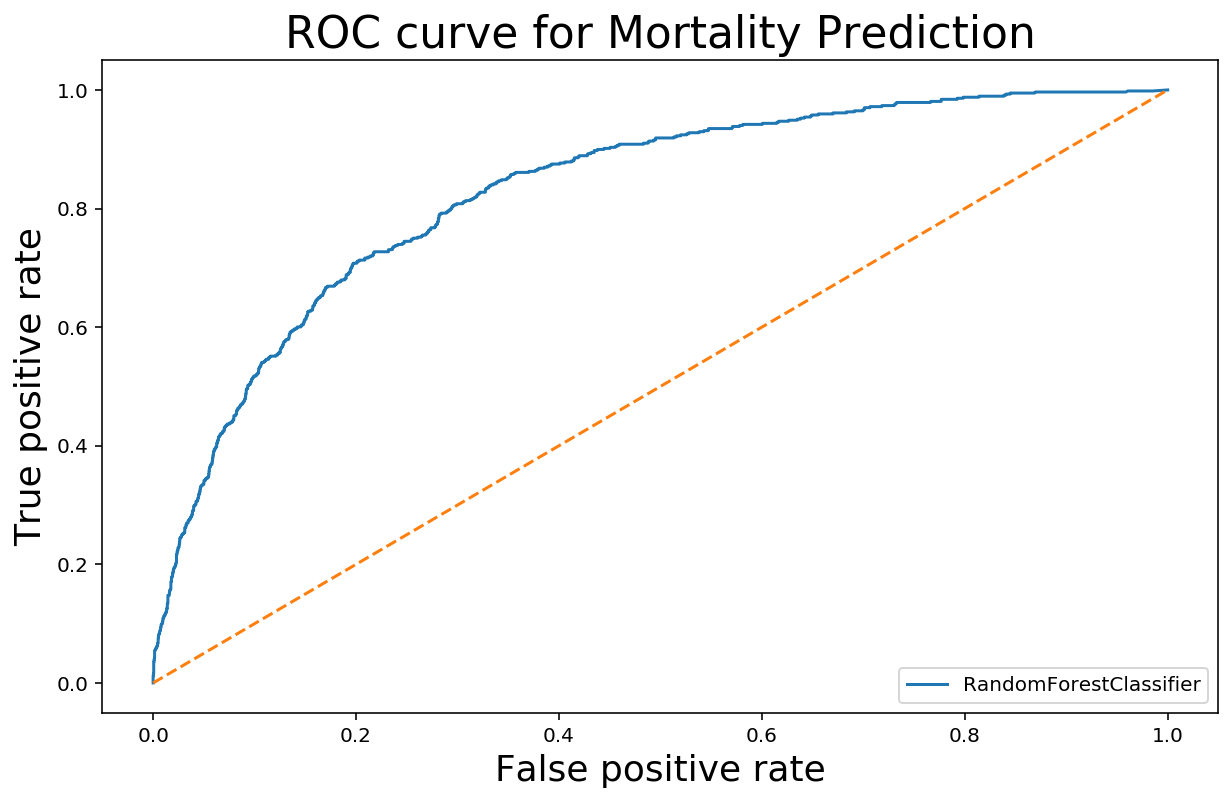

In [85]:
plot_AUC(X_te, y_test, rf_all)

## Exploring FBProphet Anomaly data

In [481]:
pickle_in = open("anomaly_train.pickle","rb")
anomaly_train = pickle.load(pickle_in)
pickle_in = open("anomaly_test.pickle","rb")
anomaly_test = pickle.load(pickle_in)

In [155]:
yXstring = 'Outcome ~ NISysABP_I + NIDiasABP_I + NIMAP_I + SysABP_I + DiasABP_I + MAP_I + Temp_I + HR_I + Weight_I + NISysABP_A + NIDiasABP_A + NIMAP_A + SysABP_A + DiasABP_A + MAP_A + Temp_A + HR_A + Weight_A'
y, X = patsy.dmatrices(yXstring, data=anomaly_train, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Outcome   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.187
Date:                Sun, 04 Aug 2019   Prob (F-statistic):            0.00263
Time:                        04:36:26   Log-Likelihood:                -1404.1
No. Observations:                4000   AIC:                             2846.
Df Residuals:                    3981   BIC:                             2966.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1198      0.020      5.926      0.000       0.080       0.159
NISysABP_I      0.9641      0.688      1.401      0.161      -0.385       2.313
NIDiasABP_I    -0.6544      0.766     -0.854      0.393      -2.157       0.848
NIMAP_I        -0.1593      0.265     -0.601      0.548      -0.679       0.360
SysABP_I        0.0723      1.123      0.064      0.949      -2.128       2.273
DiasABP_I       0.2022      0.477      0.424      0.672      -0.733       1.137
MAP_I           0.1293      0.203      0.636      0.525      -0.270       0.528
Temp_I         -0.2715      0.476     -0.571      0.568      -1.204       0.661
HR_I            1.2010      1.447      0.830      0.407      -1.637       4.039
Weight_I       -0.0309      0.048     -0.638      0.523      -0.126       0.064
NISysABP_A     -0.0001      0.006     -0.025      0.980      -0.011       0.011
NIDiasABP_A     0.0097      0.006      1.652      0.099      -0.002       0.021
NIMAP_A        -0.0079      0.006     -1.293      0.196      -0.020       0.004
SysABP_A        0.0052      0.005      1.081      0.280      -0.004       0.015
DiasABP_A       0.0140      0.005      2.865      0.004       0.004       0.024
MAP_A          -0.0203      0.005     -4.037      0.000      -0.030      -0.010
Temp_A         -0.0056      0.005     -1.225      0.221      -0.014       0.003
HR_A            0.0083      0.004      2.037      0.042       0.000       0.016
Weight_A       -0.0075      0.004     -2.084      0.037      -0.015      -0.000
==============================================================================
Omnibus:                     1450.601   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3745.601
Skew:                           2.063   Prob(JB):                         0.00
Kurtosis:                       5.336   Cond. No.                     1.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [261]:
pickle_in = open("final_train.pickle","rb")
final_train = pickle.load(pickle_in)
pickle_in = open("final_test.pickle","rb")
final_test = pickle.load(pickle_in)

y_train, X_train= final_train['Outcome'], final_train.drop(columns = ['Outcome','RecordID'])
y_test, X_test = final_test['Outcome'], final_test.drop(columns = ['Outcome','RecordID'])
X_tr, X_te = scale(X_train, X_test)

In [259]:
logit = LogisticRegression(C = 1, solver = 'lbfgs')
logit.fit(X_tr, y_train)
print_f1(logit, X_te, y_test)

The max score for LogisticRegression is
Test set:  49.45% at a threshold of 0.206


In [262]:
rf = RandomForestClassifier(bootstrap = True,
 max_depth = 90,
 max_features = 3,
 min_samples_leaf= 3,
 min_samples_split= 10,
 n_estimators= 100)
rf.fit(X_tr, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [263]:
print_f1(rf, X_te, y_test)

The max score for RandomForestClassifier is
Test set:  50.12% at a threshold of 0.257


### No improvement with anomaly features. 
Note that the anomaly detection was not run on cleaned data, with further time I would like to clean the data better and try again. Or perhaps use product of mean/number of anomalies.

# Final Contest Score:

In [534]:
print("Actual score (without cheating) is: " + str(min_threshold(xgb, .290, X_va, y_val)))

Actual score (without cheating) is: 0.517948717948718


And to maximize the validation set score by tuning threshold to the validation set (which obviously I couldn't do if this were the real competition):

In [535]:
print_score(xgb, X_va, y_val)

The max score for XGBClassifier is
Test set:  52.30% at a threshold of 0.286


I would have placed 3rd, whoo!. 7 years after the fact. <br>

## Conclusion
With a recall/precision score around 50%, I feel the model can assist hospital personel in the ICU to accomodate resources for sick patients accordingly, but there is a tremendous amount of domain knowledge I currently lack. Further investigation will be necessary: I know the reference ranges of most of the labs, but that isn't really a good indicator of patient health in it of itself. Working with actual doctors could provide insight needed to do better feature engineering.<br>

***
# Part 2
***

## Testing Other Models
Along with anomaly detection, I tested many other models and strategies to attempt to improve my score over the logistic one, but the logistic model with a threshold of .27 ultimately performed better than all of my other models on the test data (and it would turn out, also on the validation set used to score the contest). In different situations, Naive Bayes, RandomForestClassifier, XGBoost, and VotingClassifier all came close or beat LogisticRegression, but not in the final test set score. 

### Cross Validation

Up to now, I've been using the designated train data and test data for modeling, but the end goal is to maximize the finall score on the validation set, so I will just simply dump all the data together and do cross validation, bagging, etc. Also, I will now try all the models.

In [536]:
all_all = pd.concat([all_train, all_test])
X, y = all_all.drop(columns = 'Outcome'), all_all['Outcome']

In [537]:
std = StandardScaler()
std.fit(X)
X_scaled = std.transform(X)

In [539]:
log = LogisticRegression(solver = 'lbfgs')
nb = BernoulliNB()
dt = DecisionTreeClassifier(max_depth = 5)
rf = RandomForestClassifier(n_estimators = 100)
lscv = LinearSVC()
pscv = SVC(kernel = 'poly', gamma='auto')
xgb = XGBClassifier()

In [540]:
models = [log, nb, dt, rf, lscv, pscv, xgb]
modelCV = []

In [541]:
logCV = cross_val_score(log, X_scaled, y, cv = 5, scoring = 'f1')
nbCV = cross_val_score(nb, X_scaled, y, cv = 5, scoring = 'f1')
dtCV = cross_val_score(dt, X_scaled, y, cv = 5, scoring = 'f1')
rfCV = cross_val_score(rf, X_scaled, y, cv = 5, scoring = 'f1')
linearCV = cross_val_score(lscv, X_scaled, y, cv = 5, scoring = 'f1')
polyCV = cross_val_score(pscv, X_scaled, y, cv = 5, scoring = 'f1')
xgb = cross_val_score(xgb, X_scaled, y, cv = 5, scoring = 'f1')

/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/isaackim/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase th

In [542]:
print("Logistic Regression CV Score is : " + str(logCV.mean()))
print("Naive Bayes CV Score is : " + str(nbCV.mean()))
print("Decision Tree CV Score is : " + str(dtCV.mean()))
print("Random Forest CV Score is : " + str(rfCV.mean()))
print("Linear SVC CV Score is : " + str(linearCV.mean()))
print("Polynomial SVC CV Score is : " + str(polyCV.mean()))
print("XGBoost CV Score is : " + str(polyCV.mean()))

Logistic Regression CV Score is : 0.30271071376641484
Naive Bayes CV Score is : 0.35877332211639357
Decision Tree CV Score is : 0.27478231146306403
Random Forest CV Score is : 0.2682778527932517
Linear SVC CV Score is : 0.2108192634562828
Polynomial SVC CV Score is : 0.2320412235490839
XGBoost CV Score is : 0.2320412235490839


In [545]:
def min_score(model, X, y):
    return min(precision_score(y, model.predict(X)), recall_score(y, model.predict(X)))

### Oversampling

In [264]:
#Bring in combined data with these features
pickle_in = open("all_train.pickle","rb")
all_train = pickle.load(pickle_in)
pickle_in = open("all_test.pickle","rb")
all_test = pickle.load(pickle_in)
pickle_in = open("all_val.pickle","rb")
all_val = pickle.load(pickle_in)
X_train, y_train= all_train.drop(columns = ['Outcome','RecordID']), all_train['Outcome']
X_test, y_test = all_test.drop(columns = ['Outcome','RecordID']), all_test['Outcome']
X_val, y_val = all_val.drop(columns = ['Outcome','RecordID']), all_val['Outcome']
X_tr, X_te, X_va = scale(X_train, X_test, X_val)

In [567]:
# Now add some random oversampling of the minority classes
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_tr,y_train)

In [568]:
#And throw all of the models at it
clf_ros = SVC(gamma='auto').fit(X_resampled, y_resampled)
dec_ros = DecisionTreeClassifier(max_depth = 5).fit(X_resampled, y_resampled)
ran_ros = RandomForestClassifier(n_estimators = 100).fit(X_resampled, y_resampled)
log_ros = LogisticRegression(solver='lbfgs').fit(X_resampled, y_resampled)
xgb_ros = XGBClassifier().fit(X_resampled, y_resampled)

In [575]:
print(f1_score(y_train, clf_ros.predict(X_tr)))
print(f1_score(y_train, dec_ros.predict(X_tr)))
print(f1_score(y_train, ran_ros.predict(X_tr)))
print(f1_score(y_train, log_ros.predict(X_tr)))
print(f1_score(y_train, xgb_ros.predict(X_tr)))

0.7562904385334291
0.4935672514619883
1.0
0.43813604713444027
0.6294155427103404


In [570]:
print(f1_score(y_test, clf_ros.predict(X_te)))
print(f1_score(y_test, dec_ros.predict(X_te)))
print(f1_score(y_test, ran_ros.predict(X_te)))
print(f1_score(y_test, log_ros.predict(X_te)))
print(f1_score(y_test, xgb_ros.predict(X_te)))

0.39359698681732574
0.3769322235434007
0.149618320610687
0.46254071661237783
0.5065176908752328


Seems like some severe overfitting. No imporvement to the XGB score. How about SMOTE?

In [576]:
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_tr,y_train)

In [577]:
clf_smote = SVC(gamma='auto').fit(X_smoted, y_smoted)
dec_smote = DecisionTreeClassifier(max_depth = 5).fit(X_smoted, y_smoted)
ran_smote = RandomForestClassifier(n_estimators = 100).fit(X_smoted, y_smoted)
log_smote = LogisticRegression(C=.95, solver='lbfgs').fit(X_smoted, y_smoted)
xgb_smote = XGBClassifier().fit(X_smoted, y_smoted)

In [578]:
print(f1_score(y_train, clf_smote.predict(X_tr)))
print(f1_score(y_train, dec_smote.predict(X_tr)))
print(f1_score(y_train, ran_smote.predict(X_tr)))
print(f1_score(y_train, log_smote.predict(X_tr)))
print(f1_score(y_train, xgb_smote.predict(X_tr)))

0.7327285415212841
0.449489216799092
1.0
0.43324396782841823
0.6095505617977527


In [579]:
print(f1_score(y_test, clf_smote.predict(X_te)))
print(f1_score(y_test, dec_smote.predict(X_te)))
print(f1_score(y_test, ran_smote.predict(X_te)))
print(f1_score(y_test, log_smote.predict(X_te)))
print(f1_score(y_test, xgb_smote.predict(X_te)))

0.26022304832713755
0.4128891316220644
0.39397201291711526
0.45105953582240155
0.47381144238517325


In [580]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_tr,y_train)

In [581]:
clf_adasyn = SVC(gamma='auto').fit(X_adasyn, y_adasyn)
dec_adasyn = DecisionTreeClassifier(max_depth = 5).fit(X_adasyn, y_adasyn)
ran_adasyn = RandomForestClassifier(n_estimators = 100).fit(X_adasyn, y_adasyn)
log_adasyn = LogisticRegression(C=.95, solver='lbfgs').fit(X_adasyn, y_adasyn)
xgb_adasyn = XGBClassifier().fit(X_adasyn, y_adasyn)

In [582]:
print(f1_score(y_train, clf_adasyn.predict(X_tr)))
print(f1_score(y_train, dec_adasyn.predict(X_tr)))
print(f1_score(y_train, ran_adasyn.predict(X_tr)))
print(f1_score(y_train, log_adasyn.predict(X_tr)))
print(f1_score(y_train, xgb_adasyn.predict(X_tr)))

0.7210702341137124
0.41298212605832557
1.0
0.42946058091286304
0.6059763724808895


In [583]:
print(f1_score(y_test, clf_adasyn.predict(X_te)))
print(f1_score(y_test, dec_adasyn.predict(X_te)))
print(f1_score(y_test, ran_adasyn.predict(X_te)))
print(f1_score(y_test, log_adasyn.predict(X_te)))

0.29171528588098017
0.3686553873552983
0.34529147982062786
0.44124700239808157


Oversampling doesn't seem to make much of a difference with any of the models.

### Ensemble Kitchen Sink Approach

In [265]:
from sklearn import ensemble
from mlxtend.classifier import StackingClassifier 

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor)

from sklearn.metrics import make_scorer

In [266]:
lr_model = LogisticRegression(solver="lbfgs")
nb_model = BernoulliNB()
knn_model = KNeighborsClassifier()
svc_model = SVC(probability=True, gamma="scale")
rf_model = ensemble.RandomForestClassifier(n_estimators=100)
et_model = ensemble.ExtraTreesClassifier(n_estimators=100)
ada_model = ensemble.AdaBoostClassifier()
xgb_model = XGBClassifier()

models = ["lr_model", "nb_model", "knn_model", "svc_model", "rf_model", "et_model", "ada_model","xgb_model"]
best_models = ["lr_model", "nb_model", "rf_model", "et_model","ada_model","xgb_model"]

In [267]:
for model_name in models:
    curr_model = eval(model_name)
    curr_model.fit(X_tr, y_train)

In [268]:
model_vars = [eval(n) for n in models]
model_list = list(zip(models, model_vars))
best_vars = [eval(n) for n in best_models]
best_list = list(zip(best_models, best_vars))

In [664]:
for model_name in models:
    curr_model = eval(model_name)
    print(f'{model_name} score: {f1_score(y_test, curr_model.predict(X_te))}')

lr_model score: 0.26944444444444443
nb_model score: 0.3358490566037736
knn_model score: 0.12012012012012012
svc_model score: 0.024263431542461
rf_model score: 0.2570621468926554
et_model score: 0.10819672131147541
ada_model score: 0.37158469945355194
xgb_model score: 0.34848484848484845


LogisticRegression ROC AUC score : 0.832076
BernoulliNB ROC AUC score : 0.776323
RandomForestClassifier ROC AUC score : 0.820056
ExtraTreesClassifier ROC AUC score : 0.837862
AdaBoostClassifier ROC AUC score : 0.824130
XGBClassifier ROC AUC score : 0.846622


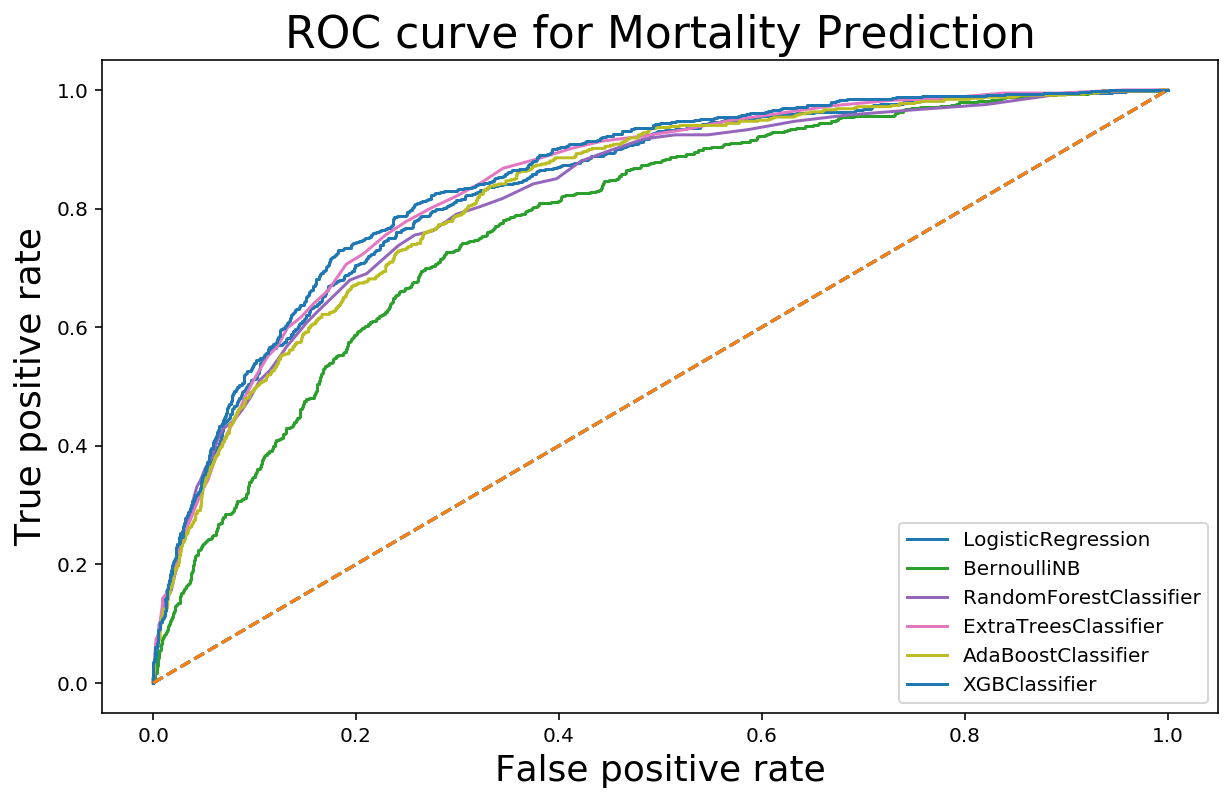

In [86]:
for model_name in best_vars:
    plot_AUC(X_te, y_test, model_name)

In [269]:
# create voting classifier
voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=4)
voting_classifier.fit(X_tr, y_train);

In [655]:
def contest_score(y_test, y_pred):
    return min(precision_score(y_test,y_pred), recall_score(y_test,y_pred))

In [270]:
y_pred = voting_classifier.predict(X_te)
f1_score(y_test, y_pred)

0.17592592592592593

In [271]:
# create voting classifier
voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=4)
voting_classifier.fit(X_tr, y_train);

In [272]:
y_pred = voting_classifier.predict(X_te)
f1_score(y_test, y_pred)

0.23919308357348704

In [290]:
f1_threshold(voting_classifier, .288, X_te, y_test)

0.5067513899920572

VotingClassifier ROC AUC score : 0.847842


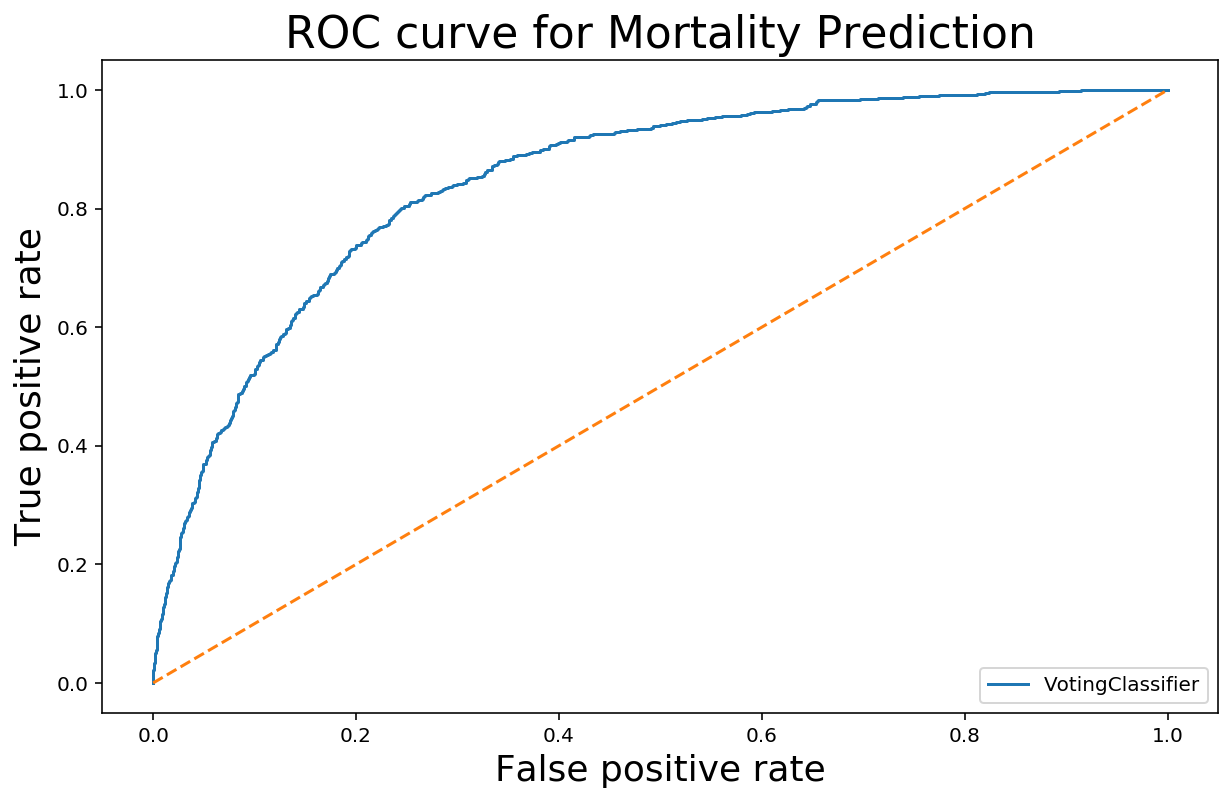

In [93]:
plot_AUC(X_te, y_test, voting_classifier)

Soft voting classifier did well on the validation data. Let's see if we can improve by filtering the best models only.

In [701]:
voting_classifier2 = VotingClassifier(estimators=best_list,
                                    voting='soft', #<-- sklearn calls this soft voting
                                    n_jobs=4)
voting_classifier2.fit(X_tr, y_train);

In [712]:
min_threshold(voting_classifier2, .343, X_te, y_test)

0.4841549295774648

Seems like no improvement. Let's try weighted classes

In [715]:
weights = [4,3,1,1,1,1,4,4]
voting_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    weights = weights,
                                    n_jobs=-1)
voting_model.fit(X_tr, y_train);

In [718]:
y_pred = voting_model.predict(X_te)
contest_score(y_test, y_pred)

0.17253521126760563

In [727]:
min_threshold(voting_model, .335, X_te, y_test)

0.4836488812392427

No improvement after multiple tries at it. 

In [740]:
stacked = StackingClassifier(
    classifiers=model_vars, meta_classifier=BernoulliNB(), use_probas=True)

In [741]:
stacked.fit(X_tr, y_train);

In [742]:
y_pred = stacked.predict(X_te)
contest_score(y_test, y_pred)

0.25018341892883345

No change observed.

### And finally, as a sanity check, let's compare with a dummy classifier.

In [749]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import BernoulliNB

In [754]:
dc = DummyClassifier()
dc.fit(X_tr, y_train)
max_score(dc, X_te, y_test)

[0.17975567190226877, 0.735]